# Feedforward Neural Network Example

The goal of this script is to get familiar with the implementation of a simple feedforward deep neural network. For the implementation we will use the deep learning library **[Pytorch](https://pytorch.org/)**. The same network could easily be also implemented in other libraries such as **[TensorFlow](https://www.tensorflow.org/)**, **[Keras](https://keras.io/)** or **[Caffe](https://caffe.berkeleyvision.org/)**. Big advantage of using dedicated neural network libraries is that all the layers and other tools are already implemented and can simply be used as building blocks to create a desired model. If available, the libraries make use of CUDA implementation of functions, which yields great improvement in terms of efficiency. Furthermore, automatic differentiation and back-propagation are implemented for all the provided functions.


**Problem setting**: In this part of the tutorial we will deal with estimating a calibration function of a terrestrial laser scanner. Assume that it is a long time since the scanner was calibrated and we suspect that the raw measurements:
    $\mathbf{x}_i = [\rho_i,\alpha_i, \beta_i]$, where $\rho$, $\alpha$ and $\beta$ are the distance, horizontal and vertical angle respectively, show systematic biases. Our data consists of the raw measurements $\mathbf{x}_i$ and the ground truth Cartesian coordinates of the measured points from which the biases of the raw measurements $\mathbf{y}_i = [\Delta\rho_i,\Delta\alpha_i, \Delta\beta_i]$ are derived as: 
    
$$\mathbf{y}_i = \mathbf{x}^\text{GT}_i - \mathbf{x}_i,$$ where

$$\mathbf{x}^{\text{GT}}_i = [\rho^{\text{GT}}_i,\alpha^{\text{GT}}_i, \beta^{\text{GT}}_i], \quad\quad \rho^{\text{GT}}_i = \sqrt{x^2_i+y^2_i+z^2_i},$$

$$\alpha^{\text{GT}}_i = \arctan{(x_i/y_i)}, \quad\quad \beta^{\text{GT}}_i = \arccos{(z_i/\rho^{\text{GT}}_i)}$$.

We would like to learn a nonlinear function $f_\theta$ that maps from the raw measurements $\mathbf{x}$ to the biases $\mathbf{y}$ in a data-driven manner. We will approximate $f_\theta$ using a feed forward neural network, where we will try to learn the parameters $\theta$ based on the training data. This can be seen as analogous approach to the more traditional setting where a parametric model e.g. Lichti (2007) would be estimated from the data using least squares adjustment. 

_Lichti, Derek D. "Error modelling, calibration and analysis of an AM–CW terrestrial laser scanner system." ISPRS journal of photogrammetry and remote sensing 61.5 (2007): 307-324._


Before we start we have to upload the data to colab, by running the section 0. As the upload can take some minutes, we will in the meantime start the exploration of the neural networks with some short exercises (See section Neural Playground
) in **[Neural Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.51677&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)**.

                                                                   
This script is given out as part of the Machine Learning Tutorial during IV2020, Munich. Please consult the slides for some background information regarding motivation and a possible physical setup for this toy example.

Written by Jemil Butt, Zan Gojcic, ETH Zurich.



  # 0. Module and data imports  ------------------------------------------------
  
 
The data is split into training, validation and test data sets. It is always very important that the split of the data is done carefully such that the test data is not included in the training data as well. The training data will be used to optimize the parameters of our network and we will monitor its performance on the validation data set. Once the training is complete we can evaluate the performance of our model on the unseen data from the test data set. Because the loading of the data takes some time we will in the mean time continue with the exercises in neural playground (see Section Neural Plyaground
)

In [ ]:
# We will first install lrcurve package that is not available by default in colab.
# In this way you can install all the python packages that are not in colab by default
!pip install lrcurve
!pip install torchviz


# Now we import all the other packages that we will need for this part of the tutorial
import torch 
from torchviz import make_dot
import numpy as np 
import os 
import matplotlib.pyplot as plt
import pandas
import time
from collections import OrderedDict
import gc
from lrcurve import PlotLearningCurve
import copy
from google.colab import files
uploaded = files.upload()

print('Packages and data successfully imported.')




Saving test_data_d_split.csv to test_data_d_split.csv
Saving train_data_d_split.csv to train_data_d_split.csv
Saving valid_data_d_split.csv to valid_data_d_split.csv
Packages and data successfully imported.


 # Neural playground  ------------------------------------------------
  
 
Neural playground is a great tool that offers possibility to explore the basic neural network concepts such as for example the non linearity, model capacity, overfitting, and regularization. Bellow you can find some exercises that target these concepts but feel free to experiment and get a feeling for training small neural networks on you own. A part of these examples was prepared by the EcoVision group at ETH Zurich.

### Linearly non-seperable data set

We will start with the classification task on the "circle" data set. This data set is not linearly separable (i.e. the points cannot be classified using only a combination of the linear features and a linear classifier). 

![Circle data set](https://drive.google.com/uc?id=1sutfkzYzQ5ts47GxSJNGh_4g_KFc3we6)

The initial setting can be found under **[initial problem setting](https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=10&networkShape=&seed=0.13495&showTestData=false&discretize=false&percTrainData=90&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)**


1. How would we solve this problem in the "traditional" machine learning setting? Which features are the most important for this data set? 

2. How could this problem be solved in the deep learning end-to-end paradigm using only the linear features as input? 


### Batch size and learning rate

We have found a possible solution to the above problem by constructing a neural network with 2 hidden layers using only the linear features as input.

The proposed solution can be found at: **[here](http://playground.tensorflow.org/#activation=relu&batchSize=30&dataset=circle&regDataset=reg-plane&learningRate=0.3&regularizationRate=0&noise=40&networkShape=4,2&seed=0.79266&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)**.

Imagine a scenario where due to the memory constraints of our setup we are forced to reduce the batch size from 30 to 4, when training our network. Monitor the loss on the training/validation data sets. Think about the following questions:

1) Is it possible to train this network with a small batch size?  

2) If yes, what parameters have to be adjusted to reach comparable or even better results than with the batch size 30?

3) What is the reason that a lower learning rate is typically selected when using smaller batch sizes? What could the relation between the batch size and the learning rate be?

### Overfitting and Regularization

We will continue with the same data set, but this time we have much less training data, which also has higher noise. The initial model that we have set up (see below) suffers from overfiting to the noise in the training data. As you can see the performance on the validation/test data set is diverging under the current setting. 

Access the **[initial configuration](https://playground.tensorflow.org/#activation=relu&batchSize=6&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=50&networkShape=8,8&seed=0.44853&showTestData=false&discretize=false&percTrainData=10&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)** and think about the following questions. 

1) How can we judge if the network is overfitting? Can this be done only using the training data set?

2) What are different ways of preventing the overfitting?

3) If we were to use the regularization what is the implication of using the L1 vs the L2 norm?

## Parameter specification

In this part of the code, all the parameters used in this coding example are specified. During the following tasks you will be requested several times to change these parameters according to the task description. Note, you **do not** have to run the above data upload every time you change the parameters.

In [ ]:

# We will also set a random seed such that the results are then comparable
np.random.seed(42)
torch.manual_seed(41)
# These are the parameters that you will be changing in order to complete the following tasks

"""
These parameters can be used to recovere the intiail parameters in case something goes wrong.
Please do not change these parameters and simply copy them to replace the exsisting parameters

l_r = 0.0001          # This parameter controls the learning rate. Valid range [0.0001, 1]
batch_size = 64       # Batch size used in the training and validation of the network. Valid range [min(n_train,n_valid,4), 2048]
p_dropout = 0         # Droupout probability [0,1). Larger value -> more neurons will be droped. 0 = no dropout layers.
n_epochs = 100        # Number of epochs to train the network. Valid range [1,500]
a_func = 'ReLu'       # Activation function to be used. Valid values 'ReLu','Sigmoid' or 'Tanh'.
n_examples = 64       # Number of training and validation examples. Valid range [64,1000]
w_decay = 0           # Value of the weight decay. Valid range [0.001, 0.5]
cartesian_loss = True # The type of loss that should be used, cartesian vs l2. loss

"""


l_r = 0.0001           # This parameter controls the learning rate. Valid range [0.0001, 1]
batch_size = 64        # Batch size used in the training and validation of the network. Valid range [64, 2048]
p_dropout = 0          # Droupout probability [0,1). Larger value -> more neurons will be droped. 0 = no dropout layers.
a_func = 'ReLu'        # Activation function to be used. Valid values 'ReLu','Sigmoid' or 'Tanh'.
n_train = 1000           # Number of training examples. Valid range [64,1000]
n_valid = 200           # Number of validation examples. Valid range [64,200]
w_decay = 0            # Value of the weight decay. Valid range [0, 0.1]
cartesian_loss = True  # The type of loss that should be used. If true l2 loss on the dervied cartesian coordinates
                       # otherwise l2 loss on the estimated biases

# Now let's check if all the parameters have valid values (if value outside the valid range is selcted the code will return an error)
assert 0.0001 <= l_r <= 1,                     "Learning rate not in valid range. Should be in range [0.0001,1]"
assert 64 <= batch_size <= 2048,                "Batch size not in valid range. Should be in range [64, 2048]"
assert 0 <= p_dropout < 1,                     "Dropout probability not in valid range. Should be in [0,1)"
assert a_func in ['ReLu', 'Sigmoid', 'Tanh'],  "Invalid activation function. Has to be 'Relu', 'Sigmoid' or 'Tanh'"
assert 64 <= n_train <= 1000,                  "Invalid num. of train examples. Valid range is [64,1000]"
assert 64 <= n_valid <= 200,                   "Invalid num. of valid examples. Valid range is [64,200]"
assert 0 <= w_decay <= 0.1,                    "Weight decay not in valid range. Valid range is [0,0.1]"

print('Packages imported. The parameters have been defined and are now \
ready for later use.')

#load the simulated laser scanning data from colab
train_data = np.genfromtxt('train_data_d_split.csv', delimiter=',')
valid_data = np.genfromtxt('valid_data_d_split.csv', delimiter=',')
test_data = np.genfromtxt('test_data_d_split.csv', delimiter=',')


# We will randomly sample the selected number of training examples from the whole training
idx_train = np.random.choice(train_data.shape[0], n_train, replace=False)
X_train = train_data[idx_train, 0:3]
Y_train = train_data[idx_train, 6:9] - train_data[idx_train, 0:3]

X_coord = train_data[idx_train,:]
X_coord_1 = train_data[idx_train,:]
print('\nTraining data contains {} examples with {} dimensions.'.format(X_train.shape[0],X_train.shape[1]))

# We will also use the number of training examples to sample a proportional number of validation examples
idx_valid = np.random.choice(valid_data.shape[0], n_valid, replace=False)
X_valid = valid_data[idx_valid, 0:3]
Y_valid = valid_data[idx_valid, 6:9] - valid_data[idx_valid, 0:3]
print('Validation data contains {} examples with {} dimensions.'.format(X_valid.shape[0],X_valid.shape[1]))

# The whole test data will be used at the end to evaluate our model
X_test = test_data[:, 0:3]
Y_test = test_data[:, 6:9] - test_data[:, 0:3]
print('Test data contains {} examples with {} dimensions.'.format(X_test.shape[0],X_test.shape[1]))

Packages imported. The parameters have been defined and are now ready for later use.

Training data contains 1000 examples with 3 dimensions.
Validation data contains 200 examples with 3 dimensions.
Test data contains 5000 examples with 3 dimensions.


# 1. Short data analysis  ------------------------------------------------

In order for our model to generalize we have to assume that the training, validation and test data are drawn from the same underlying distribution. Furthermore, typically the training data should cover the whole state space of the validation and test data. In this coding example, we are making the task for the neural network harder by considering onlythe examples with the distance of up to 15m as the training data an the examples with the distance larger than 15m as validation and test data.


### Plot the distribution of the biases in the training and validation data

In a typicall setting we do not have ground truth labels for the test data set but we can anlyze the characteristics of the training and validation data. 

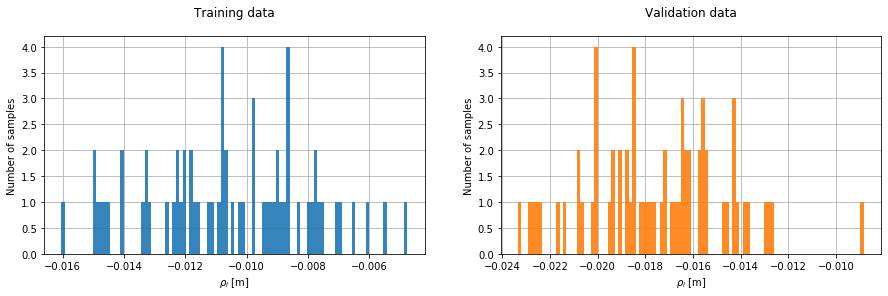

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].grid()
ax[0].hist(Y_train[:,0],100,alpha=0.9)
ax[0].set_xlabel(r'$\rho_i$ [m]')
ax[0].set_ylabel('Number of samples')
#ax[0].set_xlim([-0.75, 0.75])
ax[0].set_title('Training data', pad=20)
ax[0].set_axisbelow(True)

ax[1].hist(Y_valid[:,0],100,alpha=0.9,color='C1')
ax[1].set_title('Validation data', pad=20)
ax[1].set_xlabel(r'$\rho_i$ [m]')
ax[1].set_ylabel('Number of samples')
#ax[1].set_xlim([-0.75, 0.75])
ax[1].grid()
ax[1].set_axisbelow(True)

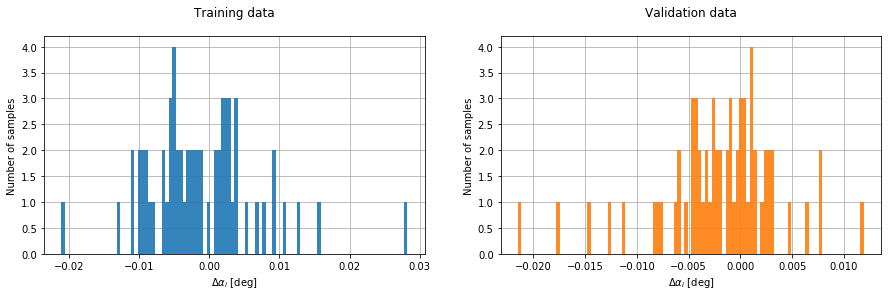

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].grid()
ax[0].hist(Y_train[:,1]*180/np.pi,100,alpha=0.9)
ax[0].set_xlabel(r'$\Delta \alpha_i$ [deg]')
ax[0].set_ylabel('Number of samples')
#ax[0].set_xlim([-0.75, 0.75])
ax[0].set_title('Training data', pad=20)
ax[0].set_axisbelow(True)

ax[1].hist(Y_valid[:,1]*180/np.pi,100,alpha=0.9,color='C1')
ax[1].set_title('Validation data', pad=20)
ax[1].set_xlabel(r'$\Delta \alpha_i$ [deg]')
ax[1].set_ylabel('Number of samples')
#ax[1].set_xlim([-0.75, 0.75])
ax[1].grid()
ax[1].set_axisbelow(True)

### Plot the distance bias as a function of the measured range

We can also analyze the relation of the distance bias to the reference distance. Does the training data cover the whole range observed in the validation data set? If we assume that the bias is strongly correlated to the ground truth distance, would we be able to predict the distance bias for the measurements of 100m using this training data?

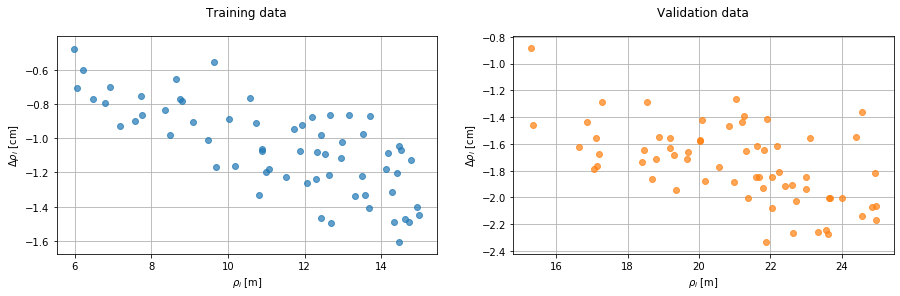

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].scatter(X_train[:,0], Y_train[:,0]*100,alpha=0.7)
#ax[0].set_ylim([-20, 20])
ax[0].set_xlabel(r'$\rho_i$ [m]')
ax[0].set_ylabel(r'$\Delta\rho_i$ [cm]')
ax[0].set_title('Training data', pad=20)
ax[0].grid()
ax[0].set_axisbelow(True)

ax[1].scatter(X_valid[:,0], Y_valid[:,0]*100 ,alpha=0.7,color='C1')
ax[1].set_xlabel(r'$\rho_i$ [m]')
ax[1].set_ylabel(r'$\Delta\rho_i$ [cm]')
ax[1].set_title('Validation data', pad=20)
ax[1].grid()
ax[1].set_axisbelow(True)

In a similar manner, other relations that might provide additional information about the distribution of the data and the correlations can be ploted.

# 2. Auxiliary functions ----------------------------------------------------

Here we define some auxiliary functions that we will use in setting up, training, and evaluation of our network. You do not have to change any part of this code, but you can have a look at how the neural network and other function are defined.

In [ ]:
class Neural_Network(torch.nn.Module):
    def __init__(self, a_func):
        super(Neural_Network, self).__init__()

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Dimension of the input, hidden layers and output
        n_dim = [3, 32, 64, 128, 256, 128, 64, 32, 3]
        layers = []
        for i in range(len(n_dim) - 2):
            # nn.Linear(input_dim,output_dim) creates a fully connected layer
            layers.append(('cov_{}'.format(i), torch.nn.Linear(n_dim[i], n_dim[i + 1])))  # adds a fully connected layer to our network

            # Based on the input we will add a non-linear activation function
            if a_func == 'ReLu':
                layers.append(('relu_{}'.format(i), torch.nn.ReLU()))  # adds ReLU activation function to our network

            elif a_func == 'Sigmoid':
                layers.append(('sig_{}'.format(i), torch.nn.Sigmoid()))  # adds Sigmoid activation function to our network

            else:
                layers.append(('tanh_{}'.format(i), torch.nn.Tanh()))  # adds Tanh activation function to our network

            # If last hidden layer and dropout probably higher than 0 we will add a dropout layer
            if i + 1 == len(n_dim) - 2 and p_dropout != 0:
                print('Dropout added')
                layers.append(('drop_{}'.format(i), torch.nn.Dropout(p=p_dropout, inplace=False)))  # adds dropout to our network
        
        layers.append(('cov_out', torch.nn.Linear(n_dim[-2], n_dim[-1])))  # adds a fully connected layer to our network

        self.regressor = torch.nn.Sequential(OrderedDict(layers))


    def forward(self, x):
        
        return self.regressor(x)


class SimpleCustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        
        if torch.cuda.is_available():
          self.inp = torch.stack(transposed_data[0], 0).type(torch.float).cuda()
          self.bias = torch.stack(transposed_data[1], 0).type(torch.float).cuda()

    # custom memory pinning method on custom type
    
    #def pin_memory(self):
    #    self.inp = self.inp.pin_memory()
    #    self.bias = self.tgt.pin_memory()
    #    
    #    return self
    

def collate_wrapper(batch):
    """
    Collates individual training examples in a batch
    """
    return SimpleCustomBatch(batch)



def get_optimizer(model, l_r, w_decay):
    """
        Creates an Adam optimizer object for the model parameters
        based on the learning rate and weight decay parameters.
        
    """
    return torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=w_decay, betas=(0.9, 0.999))


def l2_loss(x,y):
    """
        Returns the mean value of the row-wise (example-wise) l2 loss.
    """
    
    return torch.mean(torch.norm(y-x,dim=-1))


def l2_cartesian_loss(est,gt):
    """
        Returns the mean value of the l2 loss between the Cartesian coordinates.
    """
    
    # Compute the cartesian coordiantes of the point
    
    x_est = compute_cartesian_coordinates(est)
    x_gt = compute_cartesian_coordinates(gt)
    
    return torch.mean(torch.norm(x_gt-x_est,dim=-1))


def compute_cartesian_coordinates(x):
    """
        Computes the cartesian coordinates from the polar measurements. x [d,vt,hz]
    """
    
    cos_hz = torch.cos(x[:,1])
    sin_hz = torch.sin(x[:,1])
    
    cos_vt = torch.cos(x[:,2])
    sin_vt = torch.sin(x[:,2])

    x_coord = torch.cat([torch.mul(torch.mul(x[:,0],cos_vt),cos_hz).reshape(-1,1),
                        torch.mul(torch.mul(x[:,0],cos_vt),sin_hz).reshape(-1,1),
                        torch.mul(x[:,0],sin_vt).reshape(-1,1)],dim=1)
    
    
    return x_coord

def count_parameters(model):
    """
    This function counts the number of trainable parameters of the model
    Inpu: model
    
    Output: number of parameters that require gradient
    
    """
    
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0.0
        self.sq_sum = 0.0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.sq_sum += val**2 * n
        self.var = self.sq_sum / self.count - self.avg ** 2


class Timer(object):
    """A simple timer."""

    def __init__(self):
        self.total_time = 0.
        self.calls = 0
        self.start_time = 0.
        self.diff = 0.
        self.avg = 0.

    def reset(self):
        self.total_time = 0
        self.calls = 0
        self.start_time = 0
        self.diff = 0
        self.avg = 0

    def tic(self):
        # using time.time instead of time.clock because time time.clock
        # does not normalize for multithreading
        self.start_time = time.time()

    def toc(self, average=True):
        self.diff = time.time() - self.start_time
        self.total_time += self.diff
        self.calls += 1
        self.avg = self.total_time / self.calls
        if average:
            return self.avg
        else:
            return self.diff

# 3. Initializing the model and related functions -----------------------------------

In [ ]:
# In order to initialize the network we have to provide the parameter specifiying the type of the activation
# function. In this step we do not yet perform any computation, but rather just tell pytorch, which
# modules we will use in our network and how they will be connected. Check in 2. Auxiliary functions how
# the network is defined.
model = Neural_Network(a_func)

# If our setup has a Nvidia graphic card supporting CUDA parallel computing platform, we will utilize this
# to improve the efficiency of the computations. model.cuda() command copies the model from RAM to the GPU memory.
if torch.cuda.is_available():
    model = model.cuda()

# Once the network is initialized we have to specify the optimization algorithm that we will use to perform
# stochastic gradient descent. As mentioned in the presentation the default choice is ADAM optimizer, which
# we will also use in this practical example. Think about the effect of the learning rate and weight decay 
# on the training process of the network.
optimizer = get_optimizer(model,l_r,w_decay)

# Torch DataLoader class is the default class used to load the data and apply any transformations to the data that
# we possibly want to perform before feeding it to the neural network (e.g. standardization or normalization).
# It enables different ways of handling the data, for example if our training data consists of a large set of images
# we do not need to load them all in the memory but can rather just load the files on the fly. The main advantage of 
# using the dataset and dataloader functionality is that the loading of the data can run parallel (CPU) to the
# computations of the model (GPU). In this way the latency due to loading the data is greatly reduced. When the next
# iteration starts the data is already prepared and can be directly fed to the model.

# We first initialize the dataset, providing the path to the data we want to use
dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
dataset_valid = torch.utils.data.TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(Y_valid))
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))

# The DataLoader() class then creates an iterator of the dataset based on the batch size and other funcionalities.
# For example shuffle=True denotes that the data will be randomly shuffled in each epoch. We will make a separate
# data loader for the train, validation, and test data
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                          collate_fn=collate_wrapper,
                                          pin_memory=True,
                                          shuffle=True,
                                          drop_last=True)

loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size,
                                           collate_fn=collate_wrapper,
                                           pin_memory=True,
                                           shuffle=True,
                                           drop_last=True)


loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1,
                                           collate_fn=collate_wrapper,
                                           pin_memory=True,
                                           shuffle=True,
                                           drop_last=False)

In [ ]:
# We can now check how many parameters our model has. Is this a large number? Do larger networks exist?
# How can one calculate the number of parameters on its own?

print('Our model has {} trainable parametres!'.format(count_parameters(model)))

Our model has 86915 trainable parametres!


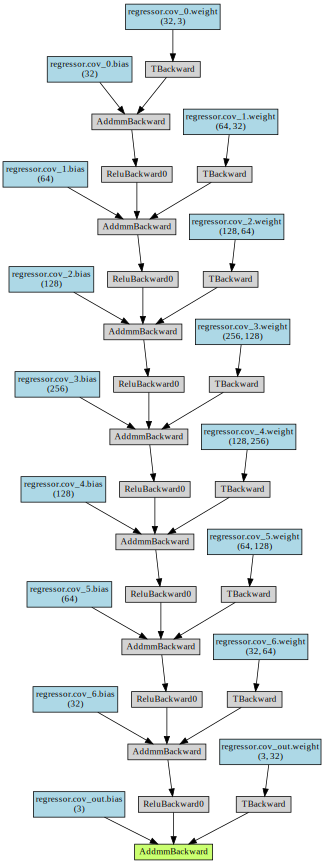

In [ ]:
# We can also make a visual inspection of the model and check if it corresponds to the desired achitecture
make_dot(model(torch.zeros(10,3).cuda()),params=dict(model.named_parameters()))

# 4. Training the network -----------------------------------

We will start with the training and evaluation of our model. The whole process will be split into smaller steps that also describe the traditional procedure when implementing and training a new network. We first have to guarantee that the implementation is correct and that there exists some functional relationship that maps the inputs to the outputs. While some steps might seem trivial, this way of designing and evaluation of the neural networks is very common. Even though neural networks are kind of a black box algorithm, we would like to understand what happens and which paramaters play a cruical . **Please run the code in section 3 every time before moving to the nest task in order to reinitialize the model with the random weights. Furthermore, only run the parts that are needed for each task (i.e. only one of the subsections of section 4)**

## 4.1 Can our network overfit a small dataset?

A good initial test in designing a neural network is to try to overfit to a small subset of the training data. In this way it is easy to see if we have any bugs in the code as well as to notice weird behavior in the training process. Think about how you would select the parameters in order to guarantee that the network will be able to overfit to the data? What kind of loss curves do we expect for the training and validation data in this case? Hint: important parameters are the number of train examples, dropout, weight decay,...

Because this test is rather quick, we will train our network for 200 epochs (epochs equal iterations in this example).

In [ ]:
# We start by intializing some objects that will hold the results for plots and print-outs
train_loss_meter, train_timer, train_time_meter = AverageMeter(), Timer(), AverageMeter()
valid_loss_meter, valid_timer, valid_time_meter = AverageMeter(), Timer(), AverageMeter()


# Training of this part is fast as each epoch is only a single iteration. Therfore, we can train for 200 epochs
n_epochs = 200

# Initialize the plot used for monitoring the training and validation loss
plot = PlotLearningCurve(xaxis_config = { 'name': 'Iteration', 'limit': [0, n_epochs*len(loader_train)]})
iteration_idx = 0

for epoch in range(n_epochs):
    
    # We first clear the excesive variables from the memory by callilng the garbage collector
    gc.collect()
    
    # The objects used to measure the effiency and track the performance of the network have to be reset after each epoch
    train_time_meter.reset()
    train_loss_meter.reset()
    train_timer.reset()
        
    # We iterate over the whole data set, performin a forward and backward pass for each batch
    for batch_ndx, batch in enumerate(loader_train):
        
        # Set the model to train mode. This tells pytorch how to use the modules that are different in the training
        # and validation stage. Which modules that were mentioned during the presentation act differently during 
        # traing and validation/test mode.
        model.train()
    
        # We need to set the gradients to zero at the start of each iteration. In the default mode pytorch
        # accumulates the gradient until we zero them out. Accumulating gradients is an important feature 
        # in training of the recurrent neural networks.
        optimizer.zero_grad()
        
        # Compute the estimated biases in a forward pass
        est_bias = model(batch.inp)
        
        # Based on the infered bias estimates, compute either the l2 loss on the estimated parameters
        # or therefrom derived cartesian coordinates
        if cartesian_loss:
            loss_train = l2_cartesian_loss(batch.inp + est_bias, batch.inp + batch.bias)
        else:
            loss_train = l2_loss(est_bias, batch.bias)
        
        train_loss_meter.update(loss_train)

        
        # After each iteration we perform validation and check the current perormance of the model

        # We reset all the objects that we use for tracking the performance
        valid_loss_meter.reset()
        valid_time_meter.reset()

        # In the validation mode the gradients of the variables are not required as there is no backpropagatio.
        # Turning off the gradients speeds up the process and reduces the memory complexity of the validation step.

        with torch.no_grad():
            
            # First set the model to the evaluation mode
            model.eval()
            for batch_ndx_valid, batch_valid in enumerate(loader_valid):
                #Compute the estimated biases in a forward pass
                est_bias_valid = model(batch_valid.inp)

                # Based on the infered bias estimates, compute either the l2 loss on the estimated parameters
                # or therefrom derived cartesian coordinates
                if cartesian_loss:
                    loss_valid = l2_cartesian_loss(batch_valid.inp + est_bias_valid, batch_valid.inp + batch_valid.bias)
                else:
                    loss_valid = l2_loss(est_bias_valid, batch_valid.bias)
                    
                valid_loss_meter.update(loss_valid)

                # Empty the cuda cache to prevent accumulation of variable in the GPU memory
                torch.cuda.empty_cache()

        
        # We plot the the learning curves in order to monitor the learning process
        plot.append(iteration_idx,{
            'loss': {
            'train': loss_train.item(),
            'validation': loss_valid.item()
            }
            })
        
        
        plot.draw()
        iteration_idx += 1
        
        # Compute the gradient of all the parameters that will be updated relative to the current loss
        loss_train.backward()
        
        # Perform the update of the parameters based on the computed gradients the properties of the optimizer
        optimizer.step()
        
        # Empty the cuda cache to prevent accumulation of variable in the GPU memory
        torch.cuda.empty_cache()
        
        
    # Print out the current loss after each epoch    
    print('Average validation loss after epoch {} equals {:.4f}'.format(epoch,valid_loss_meter.avg))
    print('Average training loss after epoch {} equals {:.4f} \n'.format(epoch,train_loss_meter.avg))
    
plot.finalize()
    

Average validation loss after epoch 0 equals 1.6758
Average training loss after epoch 0 equals 0.9307 

Average validation loss after epoch 1 equals 1.6028
Average training loss after epoch 1 equals 0.9033 

Average validation loss after epoch 2 equals 1.5298
Average training loss after epoch 2 equals 0.8761 

Average validation loss after epoch 3 equals 1.4579
Average training loss after epoch 3 equals 0.8488 

Average validation loss after epoch 4 equals 1.3877
Average training loss after epoch 4 equals 0.8213 

Average validation loss after epoch 5 equals 1.3208
Average training loss after epoch 5 equals 0.7940 

Average validation loss after epoch 6 equals 1.2601
Average training loss after epoch 6 equals 0.7670 

Average validation loss after epoch 7 equals 1.2084
Average training loss after epoch 7 equals 0.7402 

Average validation loss after epoch 8 equals 1.1652
Average training loss after epoch 8 equals 0.7136 

Average validation loss after epoch 9 equals 1.1263
Average trai

## 4.2 Using a larger data set

After confirming that out network can keep reducing the loss and can overfit a small training data set, we are confident that the implementation is correct. Now it is time to use a larger data set. Assume that we have acquired 1000 training and 200 validation examples. Please change the parameters in Section 0 accordingly and rerun section 4 before runing this section.    

In [ ]:
# We start by intializing some objects that will hold the results for plots and print-outs
train_loss_meter, train_timer, train_time_meter = AverageMeter(), Timer(), AverageMeter()
valid_loss_meter, valid_timer, valid_time_meter = AverageMeter(), Timer(), AverageMeter()

# In this step we will only train our network for 40 epochs
n_epochs = 60

# Initialize the plot used for monitoring the training and validation loss
plot = PlotLearningCurve(xaxis_config = { 'name': 'Iteration', 'limit': [0, n_epochs*len(loader_train)]})
iteration_idx = 0

for epoch in range(n_epochs):
    
    # We first clear the excesive variables from the memory by callilng the garbage collector
    gc.collect()
    
    # The objects used to measure the effiency and track the performance of the network have to be reset after each epoch
    train_time_meter.reset()
    train_loss_meter.reset()
    train_timer.reset()
        
    # We iterate over the whole data set, performin a forward and backward pass for each batch
    for batch_ndx, batch in enumerate(loader_train):
        
        # Set the model to train mode. This tells pytorch how to use the modules that are different in the training
        # and validation stage. Which modules that were mentioned during the presentation act differently during 
        # traing and validation/test mode.
        model.train()
    
        # We need to set the gradients to zero at the start of each iteration. In the default mode pytorch
        # accumulates the gradient until we zero them out. Accumulating gradients is an important feature 
        # in training of the recurrent neural networks.
        optimizer.zero_grad()
        
        # Compute the estimated biases in a forward pass
        est_bias = model(batch.inp)
        
        # Based on the infered bias estimates, compute either the l2 loss on the estimated parameters
        # or therefrom derived cartesian coordinates
        if cartesian_loss:
            loss_train = l2_cartesian_loss(batch.inp + est_bias, batch.inp + batch.bias)
        else:
            loss_train = l2_loss(est_bias, batch.bias)
        
        train_loss_meter.update(loss_train)

        
        # After each iteration we perform validation and check the current perormance of the model

        # We reset all the objects that we use for tracking the performance
        valid_loss_meter.reset()
        valid_time_meter.reset()

        # In the validation mode the gradients of the variables are not required as there is no backpropagatio.
        # Turning off the gradients speeds up the process and reduces the memory complexity of the validation step.

        with torch.no_grad():
            
            # First set the model to the evaluation mode
            model.eval()
            for batch_ndx_valid, batch_valid in enumerate(loader_valid):
                #Compute the estimated biases in a forward pass
                est_bias_valid = model(batch_valid.inp)

                # Based on the infered bias estimates, compute either the l2 loss on the estimated parameters
                # or therefrom derived cartesian coordinates
                if cartesian_loss:
                    loss_valid = l2_cartesian_loss(batch_valid.inp + est_bias_valid, batch_valid.inp + batch_valid.bias)
                else:
                    loss_valid = l2_loss(est_bias_valid, batch_valid.bias)
                    
                valid_loss_meter.update(loss_valid)

                # Empty the cuda cache to prevent accumulation of variable in the GPU memory
                torch.cuda.empty_cache()

        
        # We plot the the learning curves in order to monitor the learning process
        plot.append(iteration_idx,{
            'loss': {
            'train': loss_train.item(),
            'validation': loss_valid.item()
            }
            })
        
        
        plot.draw()
        iteration_idx += 1
        
        # Compute the gradient of all the parameters that will be updated relative to the current loss
        loss_train.backward()
        
        # Perform the update of the parameters based on the computed gradients the properties of the optimizer
        optimizer.step()
        
        # Empty the cuda cache to prevent accumulation of variable in the GPU memory
        torch.cuda.empty_cache()
        
        
    # Print out the current loss after each epoch    
    print('Average validation loss after epoch {} equals {:.4f}'.format(epoch,valid_loss_meter.avg))
    print('Average training loss after epoch {} equals {:.4f} \n'.format(epoch,train_loss_meter.avg))
    
plot.finalize()
    

Average validation loss after epoch 0 equals 0.9357
Average training loss after epoch 0 equals 0.7428 

Average validation loss after epoch 1 equals 0.4553
Average training loss after epoch 1 equals 0.4174 

Average validation loss after epoch 2 equals 0.5577
Average training loss after epoch 2 equals 0.1552 

Average validation loss after epoch 3 equals 0.3151
Average training loss after epoch 3 equals 0.0758 

Average validation loss after epoch 4 equals 0.3623
Average training loss after epoch 4 equals 0.0510 

Average validation loss after epoch 5 equals 0.2938
Average training loss after epoch 5 equals 0.0395 

Average validation loss after epoch 6 equals 0.2645
Average training loss after epoch 6 equals 0.0338 

Average validation loss after epoch 7 equals 0.2455
Average training loss after epoch 7 equals 0.0288 

Average validation loss after epoch 8 equals 0.1924
Average training loss after epoch 8 equals 0.0243 

Average validation loss after epoch 9 equals 0.1528
Average trai

## 4.3 Regularization


Relative to the number of the parameters of our network, the size of our train data set is rather small. We can observe that in the 4.2 at the end the validation loss is still much higher than the training loss, which hints that our model is overfiting. Assume that gathering additional training data is currently not possible. How can we prevent overfitting? We can try to force the network to learn a simpler function by adding the l2 norm on the paramaters of the network (weight decay). Try to set the weight decay in Section 0 to a reasonable value (hint: 0.03 is typically a god starting point) and train the network anew. Do not forget to rerun section 3 before running the code in this section.   

In [ ]:
# We start by intializing some objects that will hold the results for plots and print-outs
train_loss_meter, train_timer, train_time_meter = AverageMeter(), Timer(), AverageMeter()
valid_loss_meter, valid_timer, valid_time_meter = AverageMeter(), Timer(), AverageMeter()

# This is our final configuration so we will train the model for 100 epochs and save the best model based
# on the validation loss
n_epochs = 200
cur_best_loss = float('inf')

# Initialize the plot used for monitoring the training and validation loss
plot = PlotLearningCurve(xaxis_config = { 'name': 'Iteration', 'limit': [0, n_epochs*len(loader_train)]})
iteration_idx = 0


for epoch in range(n_epochs):
    
    # We first clear the excesive variables from the memory by callilng the garbage collector
    gc.collect()
    
    # The objects used to measure the effiency and track the performance of the network have to be reset after each epoch
    train_time_meter.reset()
    train_loss_meter.reset()
    train_timer.reset()
        
    # We iterate over the whole data set, performin a forward and backward pass for each batch
    for batch_ndx, batch in enumerate(loader_train):
        
        # Set the model to train mode. This tells pytorch how to use the modules that are different in the training
        # and validation stage. Which modules that were mentioned during the presentation act differently during 
        # traing and validation/test mode.
        model.train()
    
        # We need to set the gradients to zero at the start of each iteration. In the default mode pytorch
        # accumulates the gradient until we zero them out. Accumulating gradients is an important feature 
        # in training of the recurrent neural networks.
        optimizer.zero_grad()
        
        # Compute the estimated biases in a forward pass
        est_bias = model(batch.inp)
        
        # Based on the infered bias estimates, compute either the l2 loss on the estimated parameters
        # or therefrom derived cartesian coordinates
        if cartesian_loss:
            loss_train = l2_cartesian_loss(batch.inp + est_bias, batch.inp + batch.bias)
        else:
            loss_train = l2_loss(est_bias, batch.bias)
        
        train_loss_meter.update(loss_train)

        
        # After each iteration we perform validation and check the current perormance of the model

        # We reset all the objects that we use for tracking the performance
        valid_loss_meter.reset()
        valid_time_meter.reset()

        # In the validation mode the gradients of the variables are not required as there is no backpropagatio.
        # Turning off the gradients speeds up the process and reduces the memory complexity of the validation step.

        with torch.no_grad():
            
            # First set the model to the evaluation mode
            model.eval()
            for batch_ndx_valid, batch_valid in enumerate(loader_valid):
                #Compute the estimated biases in a forward pass
                est_bias_valid = model(batch_valid.inp)

                # Based on the infered bias estimates, compute either the l2 loss on the estimated parameters
                # or therefrom derived cartesian coordinates
                if cartesian_loss:
                    loss_valid = l2_cartesian_loss(batch_valid.inp + est_bias_valid, batch_valid.inp + batch_valid.bias)
                else:
                    loss_valid = l2_loss(est_bias_valid, batch_valid.bias)
                    
                valid_loss_meter.update(loss_valid)

                # Empty the cuda cache to prevent accumulation of variable in the GPU memory
                torch.cuda.empty_cache()

        
        # We plot the the learning curves in order to monitor the learning process
        plot.append(iteration_idx,{
            'loss': {
            'train': loss_train.item(),
            'validation': loss_valid.item()
            }
            })
        
        
        plot.draw()
        iteration_idx += 1
        
        # Compute the gradient of all the parameters that will be updated relative to the current loss
        loss_train.backward()
        
        # Perform the update of the parameters based on the computed gradients the properties of the optimizer
        optimizer.step()
        
        # Empty the cuda cache to prevent accumulation of variable in the GPU memory
        torch.cuda.empty_cache()
        
    # If current validation loss is lower than the best loss, save the best model
    if valid_loss_meter.avg < cur_best_loss:
      print('Saving model with validation loss {}'.format(valid_loss_meter.avg))
      best_model = copy.deepcopy(model)
      cur_best_loss = valid_loss_meter.avg

    # Print out the current loss after each epoch    
    print('Average validation loss after epoch {} equals {:.4f}'.format(epoch,valid_loss_meter.avg))
    print('Average training loss after epoch {} equals {:.4f} \n'.format(epoch,train_loss_meter.avg))
    
plot.finalize()
    

# 5. Final evaluation of the trained model on the test data -------------------

After we have sucsesfully trained our model, we will now evaluate it on the test data. We will use the model that was saved during the last training and will infer the 3 biases for data point. 

In [ ]:
# In this section we will use the best model that we have saved during the training. We first need to put the model to the evaluation mode.
best_model.eval()
estimated_bias = []
l2_res_model = []
l2_res_wo_corr = []

# Timer to measure the efficency of our cod
test_timer = Timer()

test_timer.tic()
for batch_ndx_test, batch_test in enumerate(loader_test):
    #Compute the estimated biases in a forward pass
    est_bias_test = best_model(batch_test.inp)
    estimated_bias.append(est_bias_test)
    # Based on the infered bias estimates, compute either the l2 loss on the estimated parameters
    # or therefrom derived cartesian coordinates
    if cartesian_loss:
        loss_model = l2_cartesian_loss(batch_test.inp + est_bias_test, batch_test.inp + batch_test.bias)
        loss_wo_corr = l2_cartesian_loss(batch_test.inp, batch_test.inp + batch_test.bias)

    else:
        loss_model = l2_loss(est_bias_test, batch_test.bias)
        loss_wo_corr = l2_loss(torch.zeros_like(batch_test.bias), batch_test.bias)
        

    l2_res_model.append(loss_model.item())
    l2_res_wo_corr.append(loss_wo_corr.item())

    # Empty the cuda cache to prevent accumulation of variable in the GPU memory
    torch.cuda.empty_cache()


combined_time = test_timer.toc()

print('Inference completed in {:.1f}s. This equals to {:.1f}ms per example.'.format(combined_time,combined_time/len(loader_test)*1000))

NameError: ignored

## Analysis of the results

To analyze the results we can plot a histrogram of residual magnitudes between the coordinates computed from the polar measurements and the GT coordinates before and after aplying the estimated correction using a NN model. Furthermore, we can compute the mean, median, and standard deviation of the residuals.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].grid()
ax[0].hist(l2_res_wo_corr,100,alpha=0.9)
ax[0].set_xlabel(r'$\Delta$ [m]')
ax[0].set_ylabel('Number of samples')
ax[0].set_xlim([0, 0.05])
ax[0].set_title('Without correction', pad=20)
ax[0].set_axisbelow(True)

ax[1].hist(l2_res_model,100,alpha=0.9,color='C1')
ax[1].set_title('With model correction', pad=20)
ax[1].set_xlabel(r'$\Delta$ [m]')
ax[1].set_ylabel('Number of samples')
ax[1].set_xlim([0, 0.05])
ax[1].grid()
ax[1].set_axisbelow(True)

In [ ]:
print('Residual magnitude before aplying the corrections. Mean {:.3f}m, Median {:.3f}m, Standard deviation {:.3f}m'.format(np.mean(l2_res_wo_corr),np.median(l2_res_wo_corr),np.std(l2_res_wo_corr)))

print('Residual magnitude after aplying the corrections. Mean {:.3f}m, Median {:.3f}m, Standard deviation {:.3f}m'.format(np.mean(l2_res_model),np.median(l2_res_model),np.std(l2_res_model)))